## Introduction

The purpose of this notebook is to - 
- Benchmark machine learning models on the [Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult) using `fastai`, `h2o` and `interpret` libraries
- Use decision tree surrogates to explain a `h2o` model
- Show how easy it is to interpret blackbox models using `interpret`

**Note**: I am not going to explain the inner mechanics of the predictive models I have used here. Rather, I will briefly explain the key points that are related to Machine Learning Explainability.

## About the dataset

[Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult) is one of the most popular datasets which is a representative of the **Finance** domain. The dataset contains 32561 records of individuals including several features like occupation, age, marital status and so on (14 features). The prediction task is to determine whether a person makes over 50K a year. 

## Simple data explorations

In [0]:
import pandas as pd

In [3]:
columns = ["Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
        "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
        "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"]

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                    header=None,
                    names=columns)

data.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [0]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,32561,NaN,NaN,NaN,38.5816,13.6404,17,28,37,48,90
WorkClass,32561,9,Private,22696,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,32561,NaN,NaN,NaN,189778,105550,12285,117827,178356,237051,1.48470e+06
Education,32561,16,HS-grad,10501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EducationNum,32561,NaN,NaN,NaN,10.0807,2.57272,1,9,10,12,16
MaritalStatus,32561,7,Married-civ-spouse,14976,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,32561,15,Prof-specialty,4140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,32561,6,Husband,13193,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,32561,5,White,27816,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,32561,2,Male,21790,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Some of the key observations

- The individuals mostly belong to **Private** _WorkClass_
- Most of the individuals are **HS-grad**
- The topmost marital status is **Married-civ-spouse**
- Most of the individuals are from **United-States **natively
- **White** is the dominant _Race_ (in the dataset)


In [0]:
data.shape

(32561, 15)

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age              32561 non-null int64
WorkClass        32561 non-null object
fnlwgt           32561 non-null int64
Education        32561 non-null object
EducationNum     32561 non-null int64
MaritalStatus    32561 non-null object
Occupation       32561 non-null object
Relationship     32561 non-null object
Race             32561 non-null object
Gender           32561 non-null object
CapitalGain      32561 non-null int64
CapitalLoss      32561 non-null int64
HoursPerWeek     32561 non-null int64
NativeCountry    32561 non-null object
Income           32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


The labels are present in the **Income** column. 

In [9]:
# Checking for missing values
data.isna().sum()

Age              0
WorkClass        0
fnlwgt           0
Education        0
EducationNum     0
MaritalStatus    0
Occupation       0
Relationship     0
Race             0
Gender           0
CapitalGain      0
CapitalLoss      0
HoursPerWeek     0
NativeCountry    0
Income           0
dtype: int64

### Class distribution in the dataset

In [0]:
from collections import Counter

classes = Counter(data['Income'].values)
class_dist = pd.DataFrame(classes.most_common(), columns=['Class', 'Num_Observations'])
class_dist

,Class,Num_Observations
0,<=50K,24720
1,>50K,7841


### How are the features correlated?

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
plt.style.use('ggplot')

%matplotlib inline

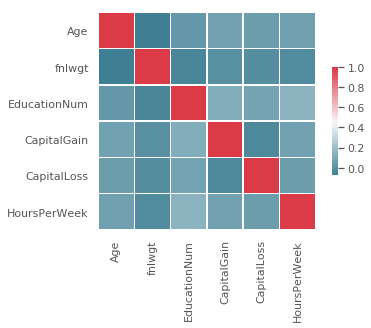

In [0]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(data.corr(), cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Start of machine learning modeling

## `fastai`

In [0]:
from fastai.tabular import * 
import torch

torch.cuda.manual_seed_all(7)

In [0]:
preprocessing = [FillMissing, Categorify, Normalize]

In [0]:
dep_var = 'Income'
cat_names = ['WorkClass', 'Education', 'MaritalStatus', 'Occupation', 'Relationship', 'Race', 'Gender', 'NativeCountry']

**I am not using a randomized validation set. Instead I am using the last 2000 entries for the purpose.**

In [0]:
valid_idx = range(len(data)-2000, len(data))

path="."

databunch = TabularDataBunch.from_df(path, data, dep_var, valid_idx=valid_idx, procs=preprocessing, cat_names=cat_names)

In [0]:
databunch.show_batch()

WorkClass,Education,MaritalStatus,Occupation,Relationship,Race,Gender,NativeCountry,fnlwgt,HoursPerWeek,Age,EducationNum,CapitalGain,CapitalLoss,target
Private,HS-grad,Married-civ-spouse,Other-service,Husband,White,Male,United-States,-0.2373,-0.0338,-1.2140,-0.4186,-0.1462,-0.2161,<=50K
Private,12th,Never-married,Craft-repair,Own-child,White,Male,United-States,0.3247,-0.0338,-1.3606,-0.8076,-0.1462,-0.2161,<=50K
Private,9th,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,0.0693,-0.0338,1.6442,-1.9748,-0.1462,-0.2161,<=50K
State-gov,Doctorate,Married-civ-spouse,Prof-specialty,Husband,White,Male,Germany,0.6094,2.4012,0.9846,2.3047,-0.1462,4.4776,>50K
State-gov,12th,Never-married,Exec-managerial,Not-in-family,White,Male,United-States,-0.0316,0.7779,-1.2140,-0.8076,-0.1462,-0.2161,>50K


### Class distribution in the train and test set after splitting

In [0]:
train_dist = Counter(databunch.train_ds.y)
pd.DataFrame(train_dist.most_common(), columns=['Classes', '#'])

,Classes,#
0,<=50K,23235
1,>50K,7326


In [0]:
valid_dist = Counter(databunch.valid_ds.y)
pd.DataFrame(valid_dist.most_common(), columns=['Classes', '#'])

,Classes,#
0,<=50K,1485
1,>50K,515


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


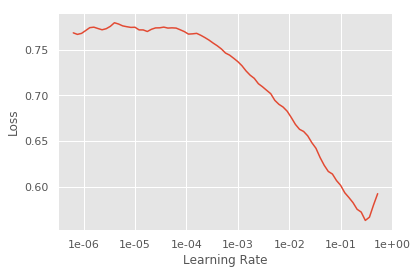

In [0]:
learn = tabular_learner(databunch, layers=[200,100], emb_szs={'NativeCountry': 10}, metrics=accuracy)
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.365516,0.350557,0.838500,00:04
1,0.321920,0.329586,0.842000,00:05
2,0.320433,0.323776,0.852000,00:04
3,0.325805,0.325966,0.847000,00:04
4,0.313125,0.323612,0.851000,00:04


**Takes seconds to train.** We get an accuracy of **85.1%**. We just supplied a good learning rate and trained the network with 1cycle policy. 

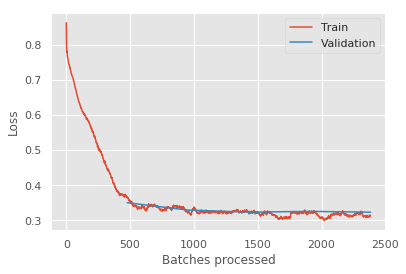

In [0]:
learn.recorder.plot_losses()

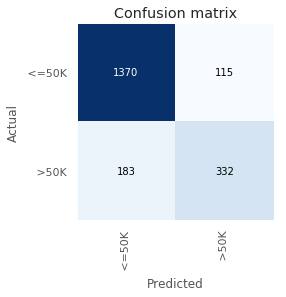

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

**The model confuses in identifying the individuals that actually earn more than 50K a year.** 

## `h20`

I will be using the [`automl`](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html) module that comes with `h2o`.

In [0]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [0]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

`h2o` models require the data to be in [H2OFrame](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html) format. 

In [6]:
# Following the same train/test split
train = data[:30561]
test = data[30561:]

train_frame = h2o.H2OFrame(train)
test_frame = h2o.h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# Verify the distribution is same
print('In the training set', Counter(train['Income']).most_common())
print('\nIn the testing set', Counter(test['Income']).most_common())

In the training set [(' <=50K', 23235), (' >50K', 7326)]

In the testing set [(' <=50K', 1485), (' >50K', 515)]


In [7]:
x = data.columns[0:-1]
y = data.columns[-1]

x, y

(Index([u'Age', u'WorkClass', u'fnlwgt', u'Education', u'EducationNum',
        u'MaritalStatus', u'Occupation', u'Relationship', u'Race', u'Gender',
        u'CapitalGain', u'CapitalLoss', u'HoursPerWeek', u'NativeCountry'],
       dtype='object'), 'Income')

In [0]:
# The targets have to be factorized before they are fed to the models in h2o
train_frame[y] = train_frame[y].asfactor()
test_frame[y] = test_frame[y].asfactor()

In [8]:
import time

aml = H2OAutoML(max_models=20, seed=1)
start = time.time()
aml.train(x=x.tolist(), y=y, training_frame=train_frame, validation_frame=test_frame)
print('AutoML took {} seconds'.format(time.time()-start))

AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML took 1899.14495087 seconds


**Takes more than half an hour of time.**

In [0]:
# An overview of how the models did within automl
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20190517_051139,0.927794,0.294853,0.173797,0.301101,0.0906617
StackedEnsemble_AllModels_AutoML_20190517_051139,0.927341,0.293938,0.177802,0.301006,0.0906044
GBM_1_AutoML_20190517_051139,0.927287,0.280554,0.172945,0.297822,0.0886982
GBM_2_AutoML_20190517_051139,0.926877,0.28149,0.174273,0.298392,0.0890378
XGBoost_grid_1_AutoML_20190517_051139_model_1,0.926558,0.281426,0.180692,0.298438,0.0890653
GBM_3_AutoML_20190517_051139,0.926515,0.281957,0.169478,0.298677,0.0892077
XGBoost_grid_1_AutoML_20190517_051139_model_4,0.926337,0.281744,0.176406,0.298589,0.0891556
XGBoost_1_AutoML_20190517_051139,0.925989,0.282082,0.181502,0.298905,0.0893445
XGBoost_grid_1_AutoML_20190517_051139_model_3,0.924797,0.285085,0.180002,0.300316,0.0901899
GBM_4_AutoML_20190517_051139,0.924704,0.285485,0.17366,0.300621,0.0903731


As we can see the best performing model is a StackedEnsemble of different models. 

In [10]:
# An extremely detailed overview of the best performing model from automl
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190517_105916
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0818098670582
RMSE: 0.286024242081
LogLoss: 0.268486688876
Null degrees of freedom: 30560
Residual degrees of freedom: 30558
Null deviance: 33663.1756673
Residual deviance: 16410.4433975
AIC: 16416.4433975
AUC: 0.942033840872
pr_auc: 0.810480622707
Gini: 0.884067681744
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.346604175412: 


,<=50K,>50K,Error,Rate
<=50K,21370.0,1865.0,0.0803,(1865.0/23235.0)
>50K,1748.0,5578.0,0.2386,(1748.0/7326.0)
Total,23118.0,7443.0,0.1182,(3613.0/30561.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3466042,0.7553660,220.0
max f2,0.1200957,0.8288704,316.0
max f0point5,0.7041231,0.7911685,103.0
max accuracy,0.4736383,0.8859003,176.0
max precision,0.9677568,1.0,0.0
max recall,0.0350344,1.0,398.0
max specificity,0.9677568,1.0,0.0
max absolute_mcc,0.3900667,0.6783781,204.0
max min_per_class_accuracy,0.1985594,0.8581764,279.0
max mean_per_class_accuracy,0.1308493,0.8620582,310.0


Gains/Lift Table: Avg response rate: 23.97 %, avg score: 24.05 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100128,0.9675329,4.1715807,4.1715807,1.0,0.9678024,1.0,0.9678024,0.0417690,0.0417690,317.1580672,317.1580672
,2,0.0200255,0.9668349,4.1715807,4.1715807,1.0,0.9672209,1.0,0.9675116,0.0417690,0.0835381,317.1580672,317.1580672
,3,0.0300056,0.9657240,4.1715807,4.1715807,1.0,0.9663176,1.0,0.9671145,0.0416325,0.1251706,317.1580672,317.1580672
,4,0.0400183,0.9634842,4.1715807,4.1715807,1.0,0.9647655,1.0,0.9665268,0.0417690,0.1669397,317.1580672,317.1580672
,5,0.0500311,0.9592896,4.1579481,4.1688524,0.9967320,0.9615759,0.9993460,0.9655359,0.0416325,0.2085722,315.7948055,316.8852365
,6,0.1000294,0.8607339,3.8030182,3.9859951,0.9116492,0.9121215,0.9555119,0.9388374,0.1901447,0.3987169,280.3018243,298.5995140
,7,0.1500278,0.7112337,3.1013846,3.6911893,0.7434555,0.7942509,0.8848419,0.8906524,0.1550642,0.5537811,210.1384583,269.1189266
,8,0.2000262,0.5004366,2.4652731,3.3847604,0.5909686,0.6083210,0.8113856,0.8200811,0.1232596,0.6770407,146.5273132,238.4760368
,9,0.3000556,0.2174322,1.6607176,2.8100168,0.3981027,0.3393037,0.6736096,0.6598045,0.1661207,0.8431613,66.0717592,181.0016773
,10,0.4000196,0.0992922,0.9490175,2.3449572,0.2274959,0.1493421,0.5621268,0.5322411,0.0948676,0.9380289,-5.0982466,134.4957250




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.0947953984135
RMSE: 0.307888613647
LogLoss: 0.303313212553
Null degrees of freedom: 1999
Residual degrees of freedom: 1997
Null deviance: 2285.11669608
Residual deviance: 1213.25285021
AIC: 1219.25285021
AUC: 0.929094831813
pr_auc: 0.781822138869
Gini: 0.858189663627
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.295499539002: 


,<=50K,>50K,Error,Rate
<=50K,1330.0,155.0,0.1044,(155.0/1485.0)
>50K,114.0,401.0,0.2214,(114.0/515.0)
Total,1444.0,556.0,0.1345,(269.0/2000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2954995,0.7488329,232.0
max f2,0.0864712,0.8341845,332.0
max f0point5,0.7486049,0.7644991,93.0
max accuracy,0.4595073,0.87,181.0
max precision,0.9677708,1.0,0.0
max recall,0.0349058,1.0,398.0
max specificity,0.9677708,1.0,0.0
max absolute_mcc,0.2954995,0.6580753,232.0
max min_per_class_accuracy,0.2075100,0.8485437,273.0
max mean_per_class_accuracy,0.1596518,0.8539472,292.0


Gains/Lift Table: Avg response rate: 25.75 %, avg score: 25.37 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9676379,3.8834951,3.8834951,1.0,0.9678777,1.0,0.9678777,0.0388350,0.0388350,288.3495146,288.3495146
,2,0.02,0.9669828,3.8834951,3.8834951,1.0,0.9673111,1.0,0.9675944,0.0388350,0.0776699,288.3495146,288.3495146
,3,0.03,0.9654732,3.8834951,3.8834951,1.0,0.9663936,1.0,0.9671942,0.0388350,0.1165049,288.3495146,288.3495146
,4,0.04,0.9637669,3.8834951,3.8834951,1.0,0.9647921,1.0,0.9665936,0.0388350,0.1553398,288.3495146,288.3495146
,5,0.05,0.9588234,3.8834951,3.8834951,1.0,0.9617010,1.0,0.9656151,0.0388350,0.1941748,288.3495146,288.3495146
,6,0.1,0.8738211,3.4174757,3.6504854,0.88,0.9194948,0.94,0.9425549,0.1708738,0.3650485,241.7475728,265.0485437
,7,0.15,0.7435795,2.8737864,3.3915858,0.74,0.8156203,0.8733333,0.9002434,0.1436893,0.5087379,187.3786408,239.1585761
,8,0.2,0.5629105,2.0582524,3.0582524,0.53,0.6569183,0.7875,0.8394121,0.1029126,0.6116505,105.8252427,205.8252427
,9,0.3,0.2609683,1.8834951,2.6666667,0.485,0.3995635,0.6866667,0.6927959,0.1883495,0.8,88.3495146,166.6666667
,10,0.4,0.1105605,1.1650485,2.2912621,0.3,0.1746481,0.59,0.5632590,0.1165049,0.9165049,16.5048544,129.1262136




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.0906647233136
RMSE: 0.301105834074
LogLoss: 0.29484706714
Null degrees of freedom: 30560
Residual degrees of freedom: 30557
Null deviance: 33664.409594
Residual deviance: 18021.6424377
AIC: 18029.6424377
AUC: 0.927758382245
pr_auc: 0.805903025954
Gini: 0.85551676449
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.332247543874: 


,<=50K,>50K,Error,Rate
<=50K,21107.0,2128.0,0.0916,(2128.0/23235.0)
>50K,1882.0,5444.0,0.2569,(1882.0/7326.0)
Total,22989.0,7572.0,0.1312,(4010.0/30561.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3322475,0.7308364,228.0
max f2,0.0956723,0.8080301,336.0
max f0point5,0.6715937,0.7663056,117.0
max accuracy,0.4519481,0.8741533,186.0
max precision,0.9682873,1.0,0.0
max recall,0.0348767,1.0,398.0
max specificity,0.9682873,1.0,0.0
max absolute_mcc,0.3830608,0.6469536,209.0
max min_per_class_accuracy,0.1820847,0.8401583,292.0
max mean_per_class_accuracy,0.1434449,0.8440924,310.0


Gains/Lift Table: Avg response rate: 23.97 %, avg score: 23.97 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100128,0.9674346,4.1715807,4.1715807,1.0,0.9679818,1.0,0.9679818,0.0417690,0.0417690,317.1580672,317.1580672
,2,0.0200255,0.9665569,4.1579481,4.1647644,0.9967320,0.9670175,0.9983660,0.9674997,0.0416325,0.0834016,315.7948055,316.4764363
,3,0.0300056,0.9654108,4.1579034,4.1624823,0.9967213,0.9660683,0.9978190,0.9670236,0.0414960,0.1248976,315.7903358,316.2482350
,4,0.0400183,0.9629986,4.1443154,4.1579369,0.9934641,0.9643011,0.9967294,0.9663424,0.0414960,0.1663937,314.4315438,315.7936908
,5,0.0500311,0.9579025,4.1170502,4.1497542,0.9869281,0.9608111,0.9947678,0.9652354,0.0412230,0.2076167,311.7050205,314.9754219
,6,0.1000294,0.8602862,3.6091817,3.8795564,0.8651832,0.9107425,0.9299967,0.9379979,0.1804532,0.3880699,260.9181707,287.9556379
,7,0.1500278,0.7068853,2.9430392,3.5674521,0.7054974,0.7910283,0.8551799,0.8890187,0.1471471,0.5352170,194.3039243,256.7452086
,8,0.2000262,0.4933410,2.3560694,3.2646560,0.5647906,0.6037839,0.7825945,0.8177217,0.1177996,0.6530167,135.6069450,226.4655968
,9,0.3000229,0.2162848,1.6025640,2.7106857,0.3841623,0.3351693,0.6497982,0.6568884,0.1602512,0.8132678,60.2564041,171.0685750
,10,0.4000196,0.0997970,1.0278797,2.2900186,0.2464005,0.1490013,0.5489571,0.5299270,0.1027846,0.9160524,2.7879662,129.0018641


In [0]:
# Get the best model to make predictions
preds = aml.leader.predict(test_frame)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [0]:
preds = h2o.as_list(preds["predict"])

In [0]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy score", accuracy_score(test['Income'].values, preds))

Accuracy score 0.865


In [0]:
!pip install scikit-plot

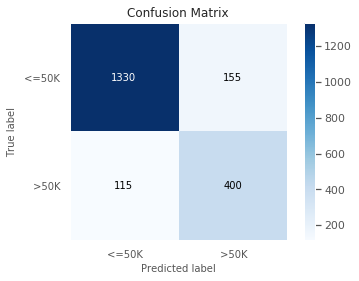

In [0]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(test['Income'].values, preds)
plt.show()

**Much improved performance than the previous one but comes at the cost of computation.** 
**Accuracy achieved: 86.5%**.

### Coming to explaining H2O models

This section mostly comes from this notebook: https://github.com/h2oai/mli-resources/blob/master/notebooks/dt_surrogate.ipynb

Check out [this repository](https://github.com/h2oai/mli-resources) to discover more resources on Machine Learning Interpretability. 

In [23]:
# Get the predictions on the training frame
train_preds = aml.predict(train_frame)['predict']
# Bind the predictions to the training frame
frame_yhat = train_frame.cbind(train_preds)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [27]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

yhat = 'predict'
model_id = 'dt_surrogate_mojo'

# Train single tree surrogate model
surrogate = H2OGradientBoostingEstimator(ntrees=1,
                                         sample_rate=1,
                                         col_sample_rate=1,
                                         max_depth=3,
                                         seed=12345,
                                         model_id=model_id)

_ = surrogate.train(x=x.tolist(), y=yhat, training_frame=frame_yhat)

mojo_path = surrogate.download_mojo(path='.')

print(surrogate)
print('Generated MOJO path:\n', mojo_path)


gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  dt_surrogate_mojo


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.170880287639
RMSE: 0.413376689762
LogLoss: 0.51935709929
Mean Per-Class Error: 0.132987744457
AUC: 0.932587883927
pr_auc: 0.836870182741
Gini: 0.865175767853
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.286452829926: 


,<=50K,>50K,Error,Rate
<=50K,20828.0,1695.0,0.0753,(1695.0/22523.0)
>50K,1533.0,6505.0,0.1907,(1533.0/8038.0)
Total,22361.0,8200.0,0.1056,(3228.0/30561.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2864528,0.8012070,5.0
max f2,0.2570147,0.8334229,6.0
max f0point5,0.3075992,0.8402175,3.0
max accuracy,0.3075992,0.8954877,3.0
max precision,0.3429557,1.0,0.0
max recall,0.2392185,1.0,7.0
max specificity,0.3429557,1.0,0.0
max absolute_mcc,0.2864528,0.7293654,5.0
max min_per_class_accuracy,0.2864528,0.8092809,5.0
max mean_per_class_accuracy,0.2864528,0.8670123,5.0


Gains/Lift Table: Avg response rate: 26.30 %, avg score: 26.44 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0179968,0.3420822,3.7882395,3.7882395,0.9963636,0.3425332,0.9963636,0.3425332,0.0681762,0.0681762,278.8239499,278.8239499
,2,0.2030693,0.3290783,3.3436125,3.3830171,0.8794201,0.3290783,0.8897841,0.3302707,0.6188106,0.6869868,234.3612492,238.3017077
,3,0.4699126,0.2570147,1.0401481,2.0526016,0.2735745,0.2642613,0.5398649,0.2927868,0.2775566,0.9645434,4.0148061,105.2601589
,4,1.0,0.2392185,0.0668882,1.0,0.0175926,0.2392185,0.2630150,0.2643909,0.0354566,1.0,-93.3111816,0.0



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-05-17 12:00:21,0.083 sec,0.0,0.4402705,0.5761869,0.5,0.0,1.0,0.7369850
,2019-05-17 12:00:21,0.151 sec,1.0,0.4133767,0.5193571,0.9325879,0.8368702,3.7882395,0.1056248


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Relationship,1814.4801025,1.0,0.5112421
Occupation,1050.2857666,0.5788356,0.2959251
CapitalGain,430.0915527,0.2370329,0.1211812
Education,252.8236847,0.1393367,0.0712348
HoursPerWeek,1.4791644,0.0008152,0.0004168
Age,0.0,0.0,0.0
WorkClass,0.0,0.0,0.0
fnlwgt,0.0,0.0,0.0
EducationNum,0.0,0.0,0.0
MaritalStatus,0.0,0.0,0.0



('Generated MOJO path:\n', '/content/dt_surrogate_mojo.zip')


In [39]:
h2o.h2o.H2OFrame(surrogate.varimp(), column_names=['Feature', 'relative_importance',	'scaled_importance', 'Percentage'])

Parse progress: |█████████████████████████████████████████████████████████| 100%


Feature,relative_importance,scaled_importance,Percentage
Relationship,1814.48,1,0.511242
Occupation,1050.29,0.578836,0.295925
CapitalGain,430.092,0.237033,0.121181
Education,252.824,0.139337,0.0712348
HoursPerWeek,1.47916,0.0008152,0.000416765
Age,0,0,0
WorkClass,0,0,0
fnlwgt,0,0,0
EducationNum,0,0,0
MaritalStatus,0,0,0


In [0]:
from IPython.display import Image
from IPython.display import display

import os
import re
import subprocess
from subprocess import CalledProcessError
import time

from h2o.backend import H2OLocalServer

In [46]:
details = False
title = 'Adult dataset Decision Tree Surrogate'

hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)

if details:
    gv_args.append('--detail')

if title is not None:
    gv_args = gv_args + ['--title', title]
    
print()
print('Calling external process ...')
print(' '.join(gv_args))
    
_ = subprocess.call(gv_args)

('Discovered H2O jar path:\n', u'/usr/local/lib/python2.7/dist-packages/h2o/backend/bin/h2o.jar')
()
Calling external process ...
java -cp /usr/local/lib/python2.7/dist-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /content/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Adult dataset Decision Tree Surrogate


In [47]:
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

print('Calling external process ...')
print(' '.join(png_args))

_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


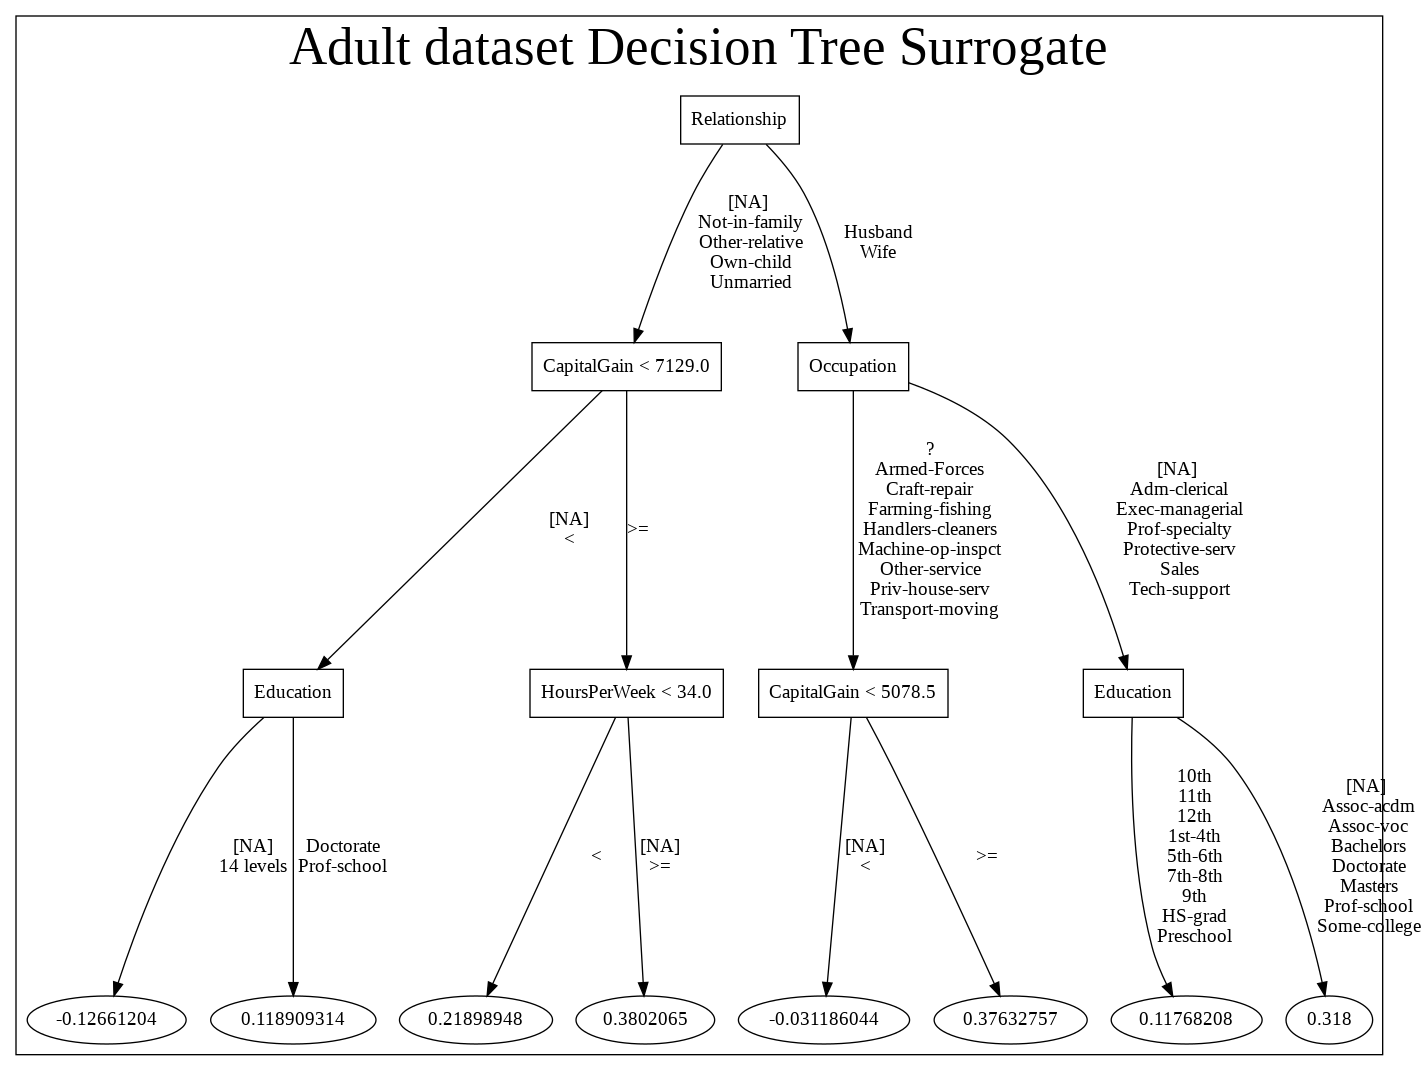

In [48]:
display(Image((png_file_name)))

From this surrogate model we see - 
- Some of the most important variables
- Important interactions
- The decision path for the most expensive houses
- The decision path for the least expensive houses




## `interpret`

**Motivation behind `interpret`**:

> Historically, the most intelligible models were not very accurate, and the most accurate models were not intelligible. Microsoft Research has developed an algorithm called the Explainable Boosting Machine (EBM)* which has both high accuracy and intelligibility.

In [0]:
!pip install pyscaffold
!pip install -U interpret

In [0]:
from interpret import show
from interpret.data import ClassHistogram

hist = ClassHistogram().explain_data(train.iloc[:, 0:-1], train['Income'], name = 'Train Data')
show(hist)

Refer to this video if you are unable to see the output of this cell: https://www.loom.com/share/1512be40265f4205a6451a97dea663e3

In [0]:
# Turning response into 0 and 1
y_train = train['Income'].apply(lambda x: 0 if x == " <=50K" else 1) 
y_test = test['Income'].apply(lambda x: 0 if x == " <=50K" else 1) 

In [0]:
from interpret.glassbox import ExplainableBoostingClassifier
import time

ebm = ExplainableBoostingClassifier(random_state=7)

start = time.time()
ebm.fit(train.iloc[:, 0:-1], y_train) 
print('It took {} seconds'.format(time.time()-start))

It took 306.07323694229126 seconds


In [0]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

If the output is not there in the above cell, here is the demo: https://www.loom.com/share/ab37697a1b70482baaf2455079f257fc

In [0]:
ebm_local = ebm.explain_local(test.iloc[:5, 0:-1], y_test[:5], name='EBM')
show(ebm_local)

Demo: https://www.loom.com/share/1655ed05299547e68bacacbbf8801ee4

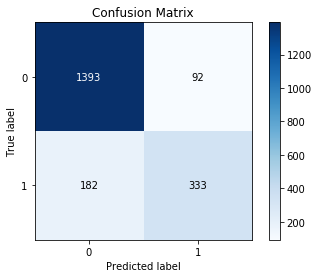

In [0]:
preds = ebm.predict(test.iloc[:, 0:-1])
skplt.metrics.plot_confusion_matrix(y_test, preds)
plt.show()

In [0]:
print(accuracy_score(y_test, preds))

0.863


- 0: <=50K
- 1: >50K

In [0]:
from sklearn.preprocessing import LabelEncoder

train_preprocessed = train.apply(LabelEncoder().fit_transform)
test_preprocessed = test.apply(LabelEncoder().fit_transform)

In [0]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
start = time.time()
rf.fit(train_preprocessed.iloc[:, 0:-1], train_preprocessed['Income'])
print('It took {} seconds'.format(time.time()-start))

It took 2.0011560916900635 seconds


In [0]:
preds = rf.predict(test_preprocessed.iloc[:, 0:-1])
accuracy_score(test_preprocessed['Income'], preds)

0.7945

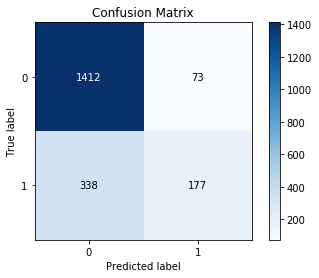

In [0]:
skplt.metrics.plot_confusion_matrix(test_preprocessed['Income'], preds)
plt.show()

In [0]:
from interpret.blackbox import LimeTabular
from interpret import show

import warnings
warnings.filterwarnings('ignore')

lime = LimeTabular(predict_fn=rf.predict_proba, data=train_preprocessed.iloc[:,0:-1], random_state=7)

lime_local = lime.explain_local(test_preprocessed.iloc[:5, 0:-1],
                                test_preprocessed['Income'][:5], name='LIME')

show(lime_local)

Demo: https://www.loom.com/share/c8e194eacb934ebabd8735b6d2300ce2

In [0]:
from interpret.blackbox import MorrisSensitivity

sensitivity = MorrisSensitivity(predict_fn=rf.predict_proba, data=train_preprocessed.iloc[:,0:-1])
sensitivity_global = sensitivity.explain_global(name="Global Sensitivity")

show(sensitivity_global)

Demo: https://www.loom.com/share/d19a9b56d97f48da85e9d02681e96b0c

In [0]:
from interpret.blackbox import PartialDependence

pdp = PartialDependence(predict_fn=rf.predict_proba, data=train_preprocessed.iloc[:,0:-1])
pdp_global = pdp.explain_global(name='Partial Dependence')

show(pdp_global)

Demo: https://www.loom.com/share/8f31af4ec336476e9d18bcac106e10b3

In [0]:
show([lime_local, sensitivity_global, pdp_global])

Demo: https://www.loom.com/share/13e1434c52d142dab06d0f7b0595983d